# Mod 3 Final Project

## Student Info

- Name: Andi Osika
- Cohort: ptds_100719
- Instructor: James Irving, PhD


## Instructions:

- Open and read the project assignment and guidelines in `MOD_PROJECT_README.ipynb`
- Review the hypothesis testing workflow found in this repo's `README.md` and at the bottom of the `MOD_PROJECT_README.ipynb`
- 3 functions from study group/learn.co lessons have been provided inside `functions.py`
    - `Cohen_d`, `find_outliers_IQR`,`find_outliers_Z`

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-mod-3-project-online-ds-ft-100719/master/Northwind_ERD_updated.png">

In [1]:
# !pip install -U fsds_100719
# from fsds_100719.imports import *

import pandas as pd


In [2]:
from functions import Cohen_d, find_outliers_IQR,find_outliers_Z

## Uncomment the line below to see the source code for the imported functions
# fs.ihelp(Cohen_d,False),fs.ihelp(find_outliers_IQR,False), fs.ihelp(find_outliers_Z,False)

In [3]:
import sqlite3
connect = sqlite3.connect('Northwind_small.sqlite')
cur = connect.cursor()

# List of Tables:

In [4]:
cur.execute("""SELECT name FROM sqlite_master WHERE type='table';""")
df_tables = pd.DataFrame(cur.fetchall(), columns=['Table'])
df_tables

,Table
0,Employee
1,Category
2,Customer
3,Shipper
4,Supplier
5,Order
6,Product
7,OrderDetail
8,CustomerCustomerDemo
9,CustomerDemographic


# HYPOTHESIS 1

> ***Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?***

- $H_0$:There is no statistcally significant effect on the quantity of a product in an order in relation to a discount amount.
- $H_1$:Discounts have a statistically significant effect on the quantiy of a product in an order.
- $H_1a$:Certain discount values have a greater effect than others.

## Importing and inspecting data from OrderDetail table:

This table includes order information on:

    1) Quantity
    2) Discount 

Will use the mean of the aggregate data of quantity ordered in comparison with orders where discounts were involved.

In [5]:
cur.execute("""SELECT * FROM OrderDetail;""")
df = pd.DataFrame(cur.fetchall(), columns=[x[0] for x in cur.description])
df.head()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [6]:
specs = df.describe()
specs

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


### Initial Visual Inspection:

From this dataset of 2155 orders, the average quantity ordered is 24 regardless of discount, the minimum ordered is 0 and max ordered is 130, although the IQR is between 10 and 30.

In [8]:
qty = df['Quantity']
qty_specs = qty.describe()
qty_specs

count    2155.000000
mean       23.812993
std        19.022047
min         1.000000
25%        10.000000
50%        20.000000
75%        30.000000
max       130.000000
Name: Quantity, dtype: float64

In [9]:
qty_mu = round(qty_specs['mean'],0)
n = len(df)
print(f'The average quantity ordered from this sample is : {qty_mu}')
print(f'There are {n} orders in this sample.')

The average quantity ordered from this sample is : 24.0
There are 2155 orders in this sample.


In [10]:
d =list(df['Discount'].unique())
d
#Dscounts are as follows:

[0.0, 0.15, 0.05, 0.2, 0.25, 0.1, 0.02, 0.03, 0.04, 0.06, 0.01]

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(qty)
plt.axvline(qty_mu, label='Qty Mean', color='purple')


In [12]:
import seaborn as sns
from ipywidgets import interact

In [13]:

@interact
def plt_discounts(d=d):
    sns.distplot(df.groupby('Discount').get_group(d)['Quantity'])
    plt.axvline(qty_mu, color='purple')
    

interactive(children=(Dropdown(description='d', options=(0.0, 0.15, 0.05, 0.2, 0.25, 0.1, 0.02, 0.03, 0.04, 0.…

In [14]:
dfa = df.groupby('Discount').count()['Quantity']
display(dfa)


Discount
0.00    1317
0.01       1
0.02       2
0.03       3
0.04       1
0.05     185
0.06       1
0.10     173
0.15     157
0.20     161
0.25     154
Name: Quantity, dtype: int64

## Initial Observations:

Datatype is numeric.  

The average quantity ordered from this sample is : 24.0
There are 2155 orders in this sample. 

Discounts are as follows:
0.0, 0.15, 0.05, 0.2, 0.25, 0.1, 0.02, 0.03, 0.04, 0.06, 0.01
The majority of product purchases are without the discount, and frequency of discounts are as follows:
5%
10%
20%
15%
25%

For discounts 1%,2%,3%,4%, and 6% , the amount of data is relatively small to evaluate it's impact on a whole.

### Since we are comparing multiple discounts to inspect it's impact on quantity ordered an AVNOVA test will be run: 
    
    
    Assumptions for ANOVA Testing: 

    1) No significant outliers 
        Upon a quick visual inspection, there appears to be some outliers that could be removed
    
    2) Equal variance
        Lavene's testing demonstrates equal variance
    
    
    3) Normality (if n>15)
          Not required for discounts: 5%, 10%, 15%, 20% and 25% since n > 15




### Remvoving outliers via Z-Scores:


In [15]:
import pandas as pd
idx_outs = find_outliers_Z(df['Quantity'])
df1 = df[~idx_outs].copy()

In [16]:
qty1 = df1['Quantity']
qty_specs1 = qty1.describe()
qty_specs1

count    2125.000000
mean       22.657882
std        16.387295
min         1.000000
25%        10.000000
50%        20.000000
75%        30.000000
max        80.000000
Name: Quantity, dtype: float64

### Revised mean for quantity ordered is 23 regardless of discount of the 2,125 orders in the revised dataset: df1

In [17]:
qty_mu1 = round(qty_specs1['mean'],0)
n1 = len(df1)
print(f'The average quantity ordered from this sample is : {qty_mu1}')
print(f'There are {n1} orders in this sample.')

The average quantity ordered from this sample is : 23.0
There are 2125 orders in this sample.


### Checking sample sizes for discounts:

For Discounts of 5%, 10%, 15%, 20% and 25% n>15 for other discounts, the qty sold is below mean, not qualifying for further testing.

In [18]:
@interact
def plt_discounts(d=d):
    sns.distplot(df1.groupby('Discount').get_group(d)['Quantity'])
    plt.axvline(qty_mu, color='purple')
    

interactive(children=(Dropdown(description='d', options=(0.0, 0.15, 0.05, 0.2, 0.25, 0.1, 0.02, 0.03, 0.04, 0.…

In [19]:
dfb = df1.groupby('Discount').count()
display(dfb)


,Id,OrderId,ProductId,UnitPrice,Quantity
Discount,,,,,
0.00,1304,1304,1304,1304,1304
0.01,1,1,1,1,1
0.02,2,2,2,2,2
0.03,3,3,3,3,3
0.04,1,1,1,1,1
0.05,181,181,181,181,181
0.06,1,1,1,1,1
0.10,170,170,170,170,170
0.15,152,152,152,152,152


### Testing for Equal Variance:

## This is an ogre way to code.. need a for loop or function here:


In [20]:
fivepercent = df1.groupby('Discount').get_group(.05)['Quantity']
tenpercent = df1.groupby('Discount').get_group(.10)['Quantity']
fifteenpercent = df1.groupby('Discount').get_group(.15)['Quantity']
twentypercent = df1.groupby('Discount').get_group(.2)['Quantity']
twentyfivepercent = df1.groupby('Discount').get_group(.25)['Quantity']

In [21]:
dataqty = df1['Quantity']

In [22]:
import scipy.stats as stats

In [23]:
def test_equal_variance(grp1,grp2, alpha=.05):
    stat,p = stats.levene(grp1,grp2)
    if p<alpha:
        print(f"Levene's test p value of {np.round(p,3)} is < {alpha}, therefore groups do NOT have equal variance.")
    else:
        print(f"Normal test p value of {np.round(p,3)} is > {alpha},  therefore groups DOES have equal variance.")
    return p

In [24]:
test_equal_variance(dataqty, fivepercent)

Normal test p value of 0.154 is > 0.05,  therefore groups DOES have equal variance.


0.1544710031524037

In [25]:
dfv = round(df1.groupby('Discount').mean(),2)['Quantity']
dfv

Discount
0.00    20.86
0.01     2.00
0.02     2.00
0.03     1.67
0.04     1.00
0.05    26.25
0.06     2.00
0.10    23.51
0.15    26.30
0.20    26.17
0.25    26.68
Name: Quantity, dtype: float64

Text(0.5, 1.0, 'Average Qty Ordered At Varying Discount Levels')

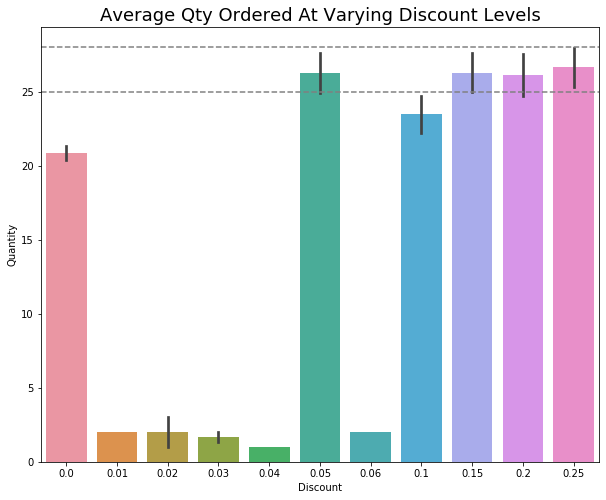

In [26]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df1, x=df1['Discount'], y=df1['Quantity'], ci=68, ax=ax)
plt.axhline(25,color='gray',ls='--')
plt.axhline(28,color='gray',ls='--')
plt.title('Average Qty Ordered At Varying Discount Levels',fontsize=18)


## ANOVA Testing:

In [27]:
stats.f_oneway(dataqty,fivepercent,tenpercent,fifteenpercent,twentypercent,twentyfivepercent)


F_onewayResult(statistic=4.817895668725112, pvalue=0.00021679426012476426)

There is a statistically significant effect on quantity purchased based on discount.


In [28]:
dft = df1.groupby('Discount').mean()
dft

,OrderId,ProductId,UnitPrice,Quantity
Discount,,,,
0.00,10661.994632,41.437883,26.154532,20.857362
0.01,11077.000000,73.000000,15.000000,2.000000
0.02,11077.000000,26.000000,18.500000,2.000000
0.03,11077.000000,31.333333,24.650000,1.666667
0.04,11077.000000,20.000000,81.000000,1.000000
0.05,10659.044199,39.265193,30.978287,26.254144
0.06,11077.000000,60.000000,34.000000,2.000000
0.10,10599.470588,41.264706,25.284000,23.505882
0.15,10655.625000,40.539474,23.052105,26.302632


In [29]:
import statsmodels.api as sms

tukey = sms.stats.multicomp.pairwise_tukeyhsd(df1['Quantity'],df1['Discount'])
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0.0,0.01,-18.8574,0.9,-71.0298,33.3151,False
0.0,0.02,-18.8574,0.848,-55.763,18.0483,False
0.0,0.03,-19.1907,0.5966,-49.3355,10.9541,False
0.0,0.04,-19.8574,0.9,-72.0298,32.3151,False
0.0,0.05,5.3968,0.0014,1.26,9.5335,True
0.0,0.06,-18.8574,0.9,-71.0298,33.3151,False
0.0,0.1,2.6485,0.6242,-1.6041,6.9012,False
0.0,0.15,5.4453,0.0043,0.9754,9.9151,True
0.0,0.2,5.3124,0.0046,0.9316,9.6933,True
0.0,0.25,5.8248,0.0015,1.3417,10.3079,True


In [30]:
Cohen_d(dataqty,tenpercent)

-0.05164732914513401

In [31]:
Cohen_d(dataqty,fifteenpercent)

-0.2211706531102785

In [32]:
Cohen_d(dataqty,twentypercent)

-0.21344989934579986

In [33]:
Cohen_d(dataqty,twentyfivepercent)

-0.24505179957472048

In [34]:
Cohen_d(dataqty,fivepercent)

-0.21670300205742482

## Hypothesis 1 Findings and Recommendation:

### Findings:
Rejecting the null hypothesis that discounts held no bearing over quantity sold.  
 In order, the following had an effect on quantity sold:
 
 * 05% discount with p value of 0.0014 and effect of .31626950124118597
 
 * 25% discount with p value of 0.0015 and effect of .24505179957472048
 
 * 15% discount with p value of 0.0043 and effect size of .2211706531102785
 
 * 20% discount with p value of 0.0046 and effect size of .21344989934579986
 
###  Recommendation:

While larger discounts did deomonstrate significant effect on quantity purchased, a 5% discount had a stronger proability of correlating to larger quantities.  To regocnize the effect of driving higher quantities purchased, offer the smaller discount to realize larger profit margins.


# Hypothesis 2

> ***What is the top selling product, of the top selling products, what are the margins?***


- $𝐻0$ : There are no products that sell at a significantly higher rate than the others.
- $𝐻1$ : There are products that sell at a higher rate than others.
- $𝐻1𝑎$ : 

In [35]:
cur.execute("""SELECT * FROM OrderDetail o
                JOIN Product p
                on o.ProductID = p.Id ;""")
prods = pd.DataFrame(cur.fetchall(), columns=[x[0] for x in cur.description])
prods.head()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,10248/11,10248,11,14.0,12,0.0,11,Queso Cabrales,5,4,1 kg pkg.,21.00,22,30,30,0
1,10248/42,10248,42,9.8,10,0.0,42,Singaporean Hokkien Fried Mee,20,5,32 - 1 kg pkgs.,14.00,26,0,0,1
2,10248/72,10248,72,34.8,5,0.0,72,Mozzarella di Giovanni,14,4,24 - 200 g pkgs.,34.80,14,0,0,0
3,10249/14,10249,14,18.6,9,0.0,14,Tofu,6,7,40 - 100 g pkgs.,23.25,35,0,0,0
4,10249/51,10249,51,42.4,40,0.0,51,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,53.00,20,0,10,0


In [36]:
prods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 16 columns):
Id                 2155 non-null object
OrderId            2155 non-null int64
ProductId          2155 non-null int64
UnitPrice          2155 non-null float64
Quantity           2155 non-null int64
Discount           2155 non-null float64
Id                 2155 non-null int64
ProductName        2155 non-null object
SupplierId         2155 non-null int64
CategoryId         2155 non-null int64
QuantityPerUnit    2155 non-null object
UnitPrice          2155 non-null float64
UnitsInStock       2155 non-null int64
UnitsOnOrder       2155 non-null int64
ReorderLevel       2155 non-null int64
Discontinued       2155 non-null int64
dtypes: float64(3), int64(10), object(3)
memory usage: 269.5+ KB


In [37]:
stats = prods['Quantity'].describe()
prods.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,SupplierId,CategoryId,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167,40.793039,14.488167,4.135499,27.948687,39.795824,8.074246,11.900232,0.105800
std,241.378032,22.159019,29.827418,19.022047,0.083450,22.159019,8.228640,2.378567,31.610706,36.055668,19.748983,10.791421,0.307653
min,10248.000000,1.000000,2.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.500000,0.000000,0.000000,0.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000,22.000000,7.000000,2.000000,12.500000,17.000000,0.000000,0.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000,41.000000,14.000000,4.000000,19.450000,25.000000,0.000000,10.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000,60.000000,21.000000,6.000000,34.000000,57.000000,0.000000,20.000000,0.000000
max,11077.000000,77.000000,263.500000,130.000000,0.250000,77.000000,29.000000,8.000000,263.500000,125.000000,100.000000,30.000000,1.000000


In [38]:
pids = prods['ProductName'].unique()
pids
print(f'There are {len(pids)} products')

There are 77 products


Visually inspecting:

In [39]:

@interact
def plt_discounts(d=pids):
    sns.distplot(prods.groupby('ProductName').get_group(d)['Quantity'])
    plt.axvline(qty_mu, color='purple')
    plt.title('Quantity Disribution')

interactive(children=(Dropdown(description='d', options=('Queso Cabrales', 'Singaporean Hokkien Fried Mee', 'M…

### Initial Visual Inspection and Data Cleaning:

In [40]:
qtystats = prods['Quantity'].describe()
qty_mu = qtystats['mean']

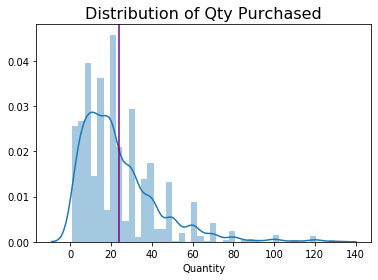

In [41]:
sns.distplot(prods['Quantity'])
plt.axvline(qty_mu, color='purple', label='Average Qty Purchased' )
plt.title('Distribution of Qty Purchased', size=(16))
plt.gca()


##### Removing Outliers:

### Adjusted Dataset

### Addditional Visual Inspection:

In [42]:
@interact
def plt_discounts(d=pids):
    sns.distplot(prods.groupby('ProductName').get_group(d)['Quantity'])
    plt.axvline(qty_mu, color='purple')

interactive(children=(Dropdown(description='d', options=('Queso Cabrales', 'Singaporean Hokkien Fried Mee', 'M…

### Initial Observations:

Datatype is numeric.  

There are 77 products, and we are looking for those that sell



### Since we are comparing multiple product quanitesto inspect it's impact on quantity ordered an AVNOVA test will be run: 
    
    
    Assumptions for ANOVA Testing: 

    1) No significant outliers 
        Upon a quick visual inspection, there appears to be some outliers that could be removed in 
    
    2) Equal variance
        Lavene's testing demonstrates equal variance
    
    
    3) Normality (if n<15)
          Not required for discounts: 5%, 10%, 15%, 20% and 25% since n > 15

#### Data Processing: 

Grouping products by ProductId and then by quantity to evaulate top 5 selling products, also calculating margins.

In [43]:
len(prods['ProductName'].unique())

77

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76]),
 <a list of 77 Text xticklabel objects>)

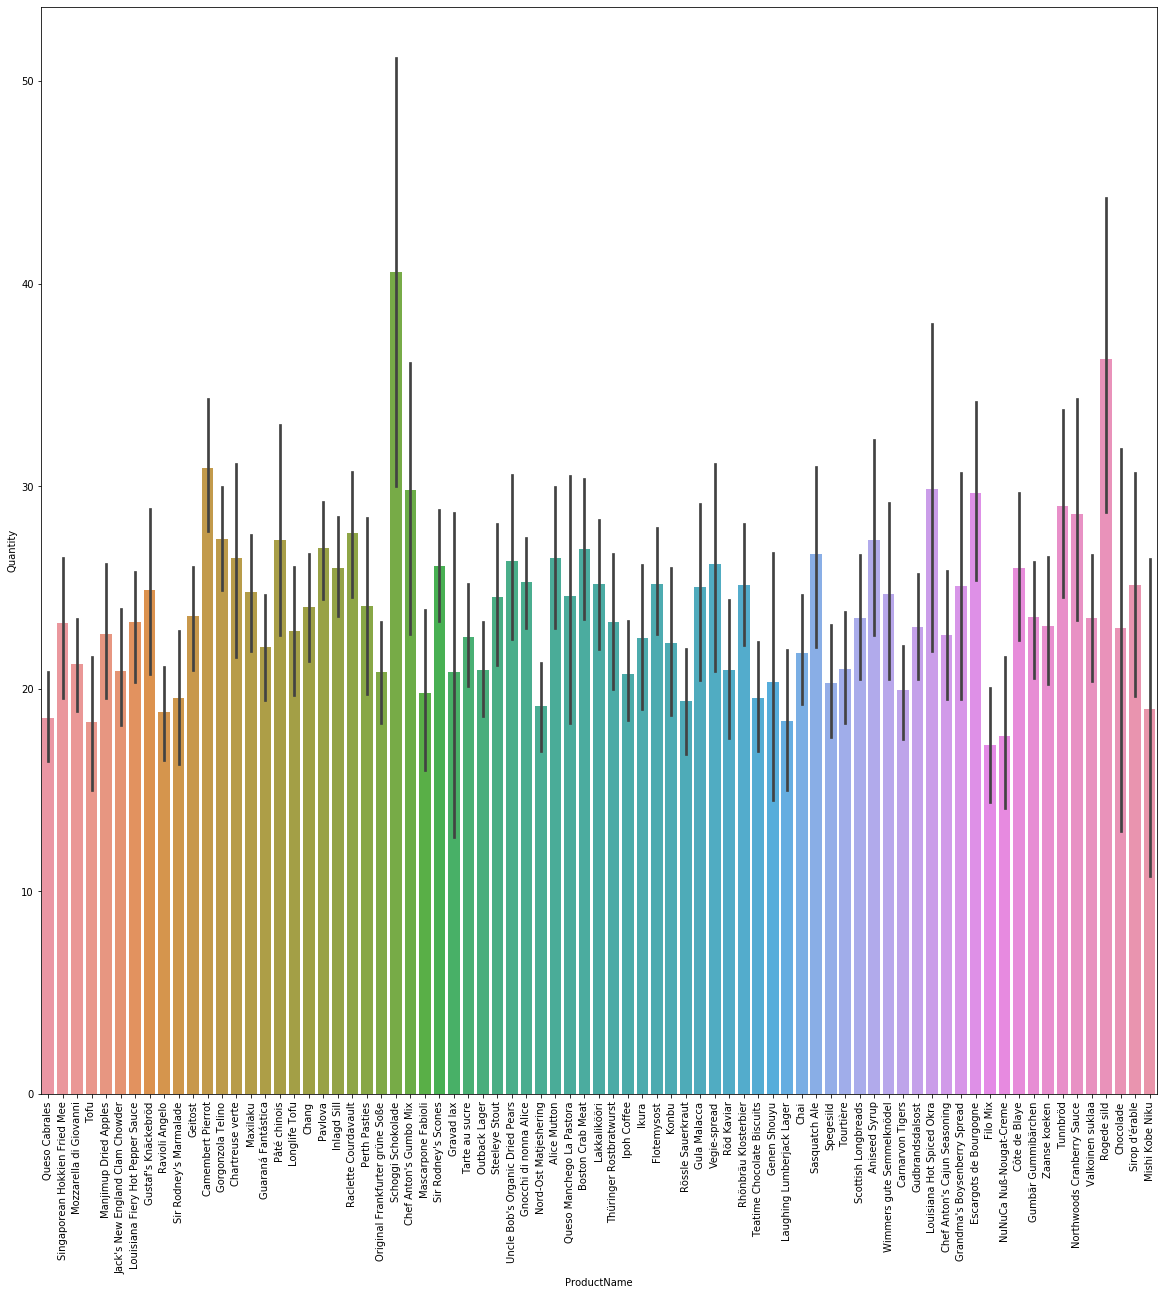

In [44]:
fig, ax = plt.subplots(figsize=(20,20))
sns.barplot(data=prods, x='ProductName', y='Quantity',ci=68)
plt.xticks(rotation=90)


In [46]:
pids ={}
for pid , qty in pids.items():
    idx_outs = find_outliers_Z(qty)
    print(f'Found {idx_outs.sum()} outliers in  {pid} using z-scores')


AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [47]:
for k,v in pids.items():
    sns.distplot(v, label=k)
ax = plt.gca()

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [ ]:
for pid , qty in pids.items():
    i = len(pid)
    print(f'There are {i} values for the product {pid}')

In [ ]:
prods_info ={}
for pid in pids: 
    prods_info[pid] = prods.groupby('ProductName').get_group(pid)


In [ ]:
# prodsqty_info ={}
# prosdmarg_info = {}
# for pid in pids: 
#     prodsqty_info[pid] = prods1.groupby('ProductId').get_group(pid)['Quantity']
#     prodsmarg_info = prods1.groupby('ProductId').get_group(pid)['Margin']

In [ ]:
prodsa = pd.DataFrame(prods_info)
top5 = prods_info.sort_values(by='Quantity',axis=1, ascending=False).loc['Margin']
top5.head()

Top 5 product ID's that are NOT discontinued are:

Product ID | Avg Qty Ordered |
---| ---| ---|
 27| 30 | 3.30|
 66 |30 |1.7|
 58 |30 | .58|
 23 | 29|.63|
  8| 29 | 3
  
  * 5(discontinued) average ordered 30

In [ ]:
top5
@interact
def plt_discounts(d=top5):
    sns.distplot(prods1.groupby('ProductId').get_group(d)['Quantity'])
    plt.axvline(qty_mu, color='purple')

In [ ]:
#Differentiating between COGs ('UnitPrice_1') and Sale Price ('UnitPrice_2') to calculate margins
cols = []
count = 1
for column in prods1.columns:
    if column == 'UnitPrice':
        cols.append(f'UnitPrice_{count}')
        count+=1
        continue
    cols.append(column)
prods1.columns = cols

In [ ]:
prods1.head()

...noting 70% of orders pull in < mean in terms of margins

# Hypothesis 3

> ***Do certain sales representatives sell more than others?  Who are the top sellers?***

$H0$: All sales representatives sell the same in revenue.

$H1$: Some sales representatives sell more than others in revenue.

### Importing and inspecting data from Product, OrderDetail, Order and Employee Tables
These table includes information on:

    1) Product information including cost of goods sold and sale price sold
    2) Sales Representative Information

In [48]:
cur.execute("""SELECT ProductID, ProductName,p.UnitPrice as COGS, Discontinued,
                OrderID, ProductID, od.UnitPrice AS SalesPrice, Quantity, Discount,
                EmployeeID, LastName, FirstName 
                FROM Product AS p
                JOIN OrderDetail AS od
                ON od.ProductID = p.Id 
                JOIN 'Order' AS o
                ON o.Id = od.OrderId
                JOIN Employee AS e
                ON o.EmployeeID = e.ID;""")
dfr = pd.DataFrame(cur.fetchall(), columns=[x[0] for x in cur.description])
dfr

,ProductId,ProductName,COGS,Discontinued,OrderId,ProductId,SalesPrice,Quantity,Discount,EmployeeId,LastName,FirstName
0,11,Queso Cabrales,21.00,0,10248,11,14.00,12,0.00,5,Buchanan,Steven
1,42,Singaporean Hokkien Fried Mee,14.00,1,10248,42,9.80,10,0.00,5,Buchanan,Steven
2,72,Mozzarella di Giovanni,34.80,0,10248,72,34.80,5,0.00,5,Buchanan,Steven
3,14,Tofu,23.25,0,10249,14,18.60,9,0.00,6,Suyama,Michael
4,51,Manjimup Dried Apples,53.00,0,10249,51,42.40,40,0.00,6,Suyama,Michael
...,...,...,...,...,...,...,...,...,...,...,...,...
2150,64,Wimmers gute Semmelknödel,33.25,0,11077,64,33.25,2,0.03,1,Davolio,Nancy
2151,66,Louisiana Hot Spiced Okra,17.00,0,11077,66,17.00,1,0.00,1,Davolio,Nancy
2152,73,Röd Kaviar,15.00,0,11077,73,15.00,2,0.01,1,Davolio,Nancy
2153,75,Rhönbräu Klosterbier,7.75,0,11077,75,7.75,4,0.00,1,Davolio,Nancy


In [49]:
dfr['Margin'] = dfr['SalesPrice'] - dfr['COGS']

dfr['SaleRev'] = dfr['SalesPrice']*dfr['Quantity']


In [50]:
empcount = len(dfr['EmployeeId'].unique())
avrev = dfr['SaleRev'].mean()
print(f'There are {empcount} employees in this company associated with sales information')
print(f'The avarage revenue generated by a sales representative is ${round(avrev)}')

There are 9 employees in this company associated with sales information
The avarage revenue generated by a sales representative is $629.0


### Hypothesis 3 Initial Visualization:

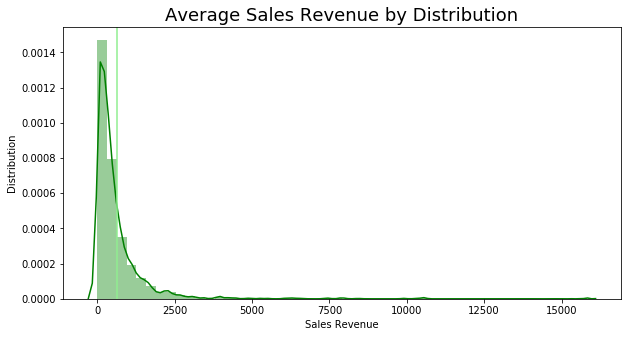

In [51]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(dfr['SaleRev'], color='green')
plt.axvline(avrev, color='lightgreen')
plt.xlabel('Sales Revenue')
plt.ylabel('Distribution')
plt.title('Average Sales Revenue by Distribution', fontsize=18)
plt.show()

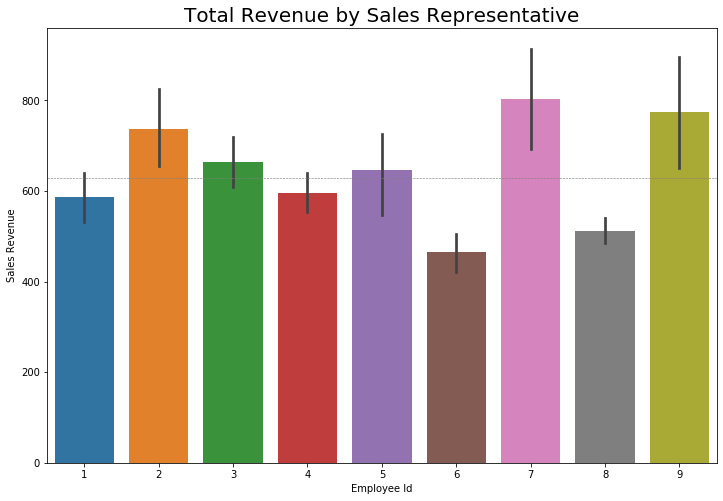

In [52]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=dfr, x='EmployeeId', y='SaleRev', ci=68, ax=ax)
plt.title('Total Revenue by Sales Representative', fontsize=20)
plt.axhline(629,linestyle="--", color='gray', linewidth=.6 )
plt.xlabel('Employee Id')
plt.ylabel('Sales Revenue')
plt.show()


In [53]:
reps = {}
for rep in dfr['EmployeeId'].unique():
    reps[rep] = dfr.groupby('EmployeeId').get_group(rep)['SaleRev']


Distributions appear roughly equal


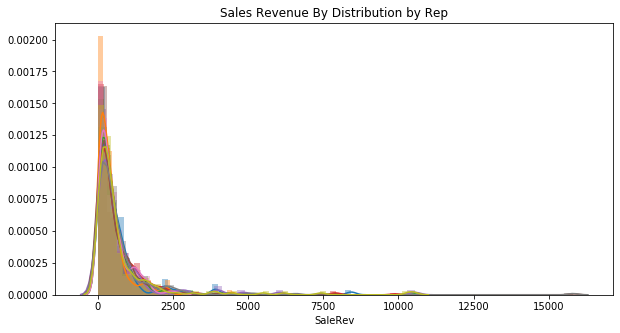

In [54]:
fig, ax = plt.subplots(figsize=(10,5))
for k,v in reps.items():
    sns.distplot(v,label=v)

plt.title('Sales Revenue By Distribution by Rep')
print('Distributions appear roughly equal')

#### Initial Observations:
Datatype is numeric in this 2155 order sample.

There are 9 employees in this company associated with sales information

The avarage revenue generated by a sales representative is $629.00. 

Initial visual inspection indicates roughly uniform distribution in sales revenue, more than half of the sales representatives achieve the average.  Additional testing will demonstrate if it is significant.

Since we are comparing multiple discounts to inspect it's impact on quantity ordered an AVNOVA test will be run:
Assumptions for ANOVA Testing: 

1) No significant outliers 
    Upon a quick visual inspection, there appears to be some outliers that could be removed

2) Equal variance
    


3) Normality (if n>15)
      Not required for samples greater than 15

#### Removing Outliers:

In [55]:
for rep, rep_data in reps.items():
    idx_outs = find_outliers_Z(rep_data)
    print(f'Found {idx_outs.sum()} outliers in Employee # {rep}')
    reps[rep] = rep_data[~idx_outs]
print('\n All of these outliers were removed')



Found 3 outliers in Employee # 5
Found 4 outliers in Employee # 6
Found 6 outliers in Employee # 4
Found 4 outliers in Employee # 3
Found 2 outliers in Employee # 9
Found 4 outliers in Employee # 1
Found 4 outliers in Employee # 8
Found 5 outliers in Employee # 2
Found 5 outliers in Employee # 7

 All of these outliers were removed


In [56]:
#### Assumptions for Normality

In [78]:
for rep,samples in reps.items():
    print(f'There are {len(samples)} samples in the data set for Employee #{rep}.')
    
print('\nAll samples are >15: Normality Assumption Criterion is met.')

There are 117 samples in the data set for Employee #5.
There are 168 samples in the data set for Employee #6.
There are 420 samples in the data set for Employee #4.
There are 321 samples in the data set for Employee #3.
There are 107 samples in the data set for Employee #9.
There are 345 samples in the data set for Employee #1.
There are 260 samples in the data set for Employee #8.
There are 241 samples in the data set for Employee #2.
There are 176 samples in the data set for Employee #7.
There are 167 samples in the data set for Employee #rep.

All samples are >15: Normality Assumption Criterion is met.


# Hypothesis 4


> ***What are the largest margins?***

$𝐻0 :$ All products have equal return on investment

$𝐻1 :$ There are products that sell at a higher margin.
𝐻1𝑎 : 



In [56]:
#differentiating between cogs and sale price with Unit Price1
cols = []
count = 1
for column in prods.columns:
    if column == 'UnitPrice':
        cols.append(f'UnitPrice_{count}')
        count+=1
        continue
    cols.append(column)
prods.columns = cols

In [57]:
#prods.rename(columns = {'UnitPrice_1':'GOGS', 'UnitPrice_2':'SalePrice'}, inplace=True)

In [58]:
prods['Margin'] = prods['UnitPrice_2'] - prods['UnitPrice_1']

In [59]:
margstats = prods['Margin'].describe()
margstats

count    2155.000000
mean        1.730167
std         4.431286
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        52.700000
Name: Margin, dtype: float64

In [60]:
marg_mu = margstats['mean']
marg_mu

1.7301670533642692

In [61]:
# prods_info = prods1.groupby('ProductId')
# topsellers = sorted(prods_info['Quantity'].sum(), reverse = True)
# topsellers

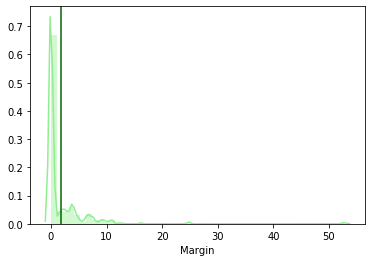

In [62]:
sns.distplot(prods['Margin'], color = 'lightgreen')
plt.axvline(marg_mu, color='darkgreen')

# Hypothesis 5

> ***Where are our customers from that spend the most money?***

$H0$: Customers do not spend more money based on their geographic location.

$H1$: Customers living in certain areas spend more than others.


    

# Hypothesis 6 (Use in Case of Emergency) 

> ***Does discount amount have a statistically significant effect on the total amount spent?***

$H0$: Customers spend the same on both discounted and regular priced items.
$H1$: C

